## Imports

In [3]:
# sklearn analytics
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Models
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering

from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Preprocessing
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,\
    TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline


# General
import warnings
import numpy as np
import pandas as pd
import nltk
import random
import os
import re
import string
import statsmodels.api as sm
from os import path
from PIL import Image
from time import time


# NLP
from nltk import sent_tokenize, word_tokenize
from nltk.util import ngrams
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
#nltk.download('stopwords')
stopwords = stopwords.words('english')
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud, STOPWORDS
from subprocess import check_output
from collections import Counter
import spacy
nlp = spacy.load('en')

# Visualization
%matplotlib inline

# Set Plot Theme
sns.set_palette([
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#551A8B",
])

# Warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

# warnings.filterwarnings('ignore')

## Data Cleaning

In [5]:
# Read and Peak at Data
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
df.drop(df.columns[0], inplace=True, axis=1)

# Delete missing observations for following variables
for x in ["Division Name", "Department Name", "Class Name", "Review Text"]:
    df = df[df[x].notnull()]

# Extracting Missing Count and Unique Count by Column
unique_count = []
for x in df.columns:
    unique_count.append([x, len(df[x].unique()), df[x].isnull().sum()])

# Missing Values
print("Missing Values: {}".format(df.isnull().sum().sum()))

# Data Dimensions
print("Dataframe Dimension: {} Rows, {} Columns".format(*df.shape))

# Create New Variables:
# Word Length
df["Word Count"] = df['Review Text'].str.split().apply(len)
# Character Length
df["Character Count"] = df['Review Text'].apply(len)

Missing Values: 2966
Dataframe Dimension: 22628 Rows, 10 Columns


## EDA

I'm interested in investigating the Recommended binary variable.

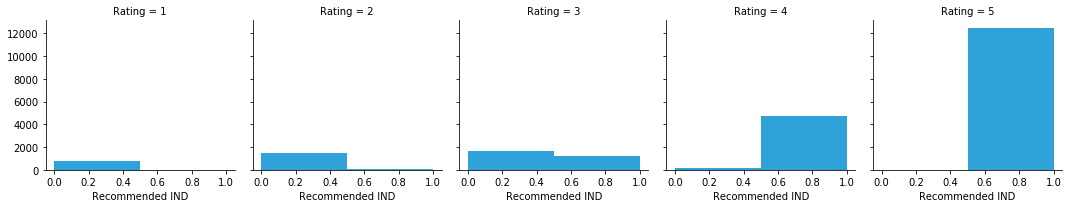

In [10]:
# Looking at if a product was recommended based on the rating.
g = sns.FacetGrid(data=df, col='Rating')
g.map(plt.hist, 'Recommended IND', bins=2)
plt.show()

For Recommended IND 1 represents if the customer recommended the product, 0 is not recommended. We can examine product recommendations relative to product rating to understand the sentiment behind review. It would seem with a rating of 1 and 2, most customers do not recommend the product. At a rating of 3 it appears customers are somewhat neutral, and at ratings above 4 customers predominantly recommend the product. 

I'll use this to engineer 3 categorical variables for sentiment.

In [7]:
# Categorical for Positive, Neautral and Negative Reviews
df["Label"] = 'Negative'
df.loc[df.Rating == 3, ["Label"]] = 'Neutral'
df.loc[df.Rating > 3, ["Label"]] = 'Positive'

# Sanity Check
df['Label'].unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

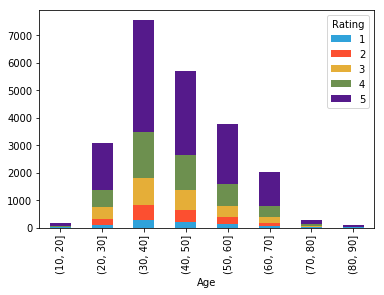

In [9]:
# Exploring rating and age distribution.
df.groupby(['Rating', pd.cut(df['Age'], np.arange(0, 100, 10))])\
    .size()\
    .unstack(0)\
    .plot.bar(stacked=True)
plt.show()

<Figure size 1080x1080 with 0 Axes>

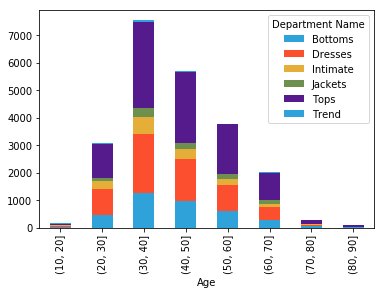

In [11]:
# Exploring Department and Age Distribution
plt.figure(figsize=(15, 15))
df.groupby(['Department Name', pd.cut(df['Age'], np.arange(0, 100, 10))])\
    .size()\
    .unstack(0)\
    .plot.bar(stacked=True)
plt.show()

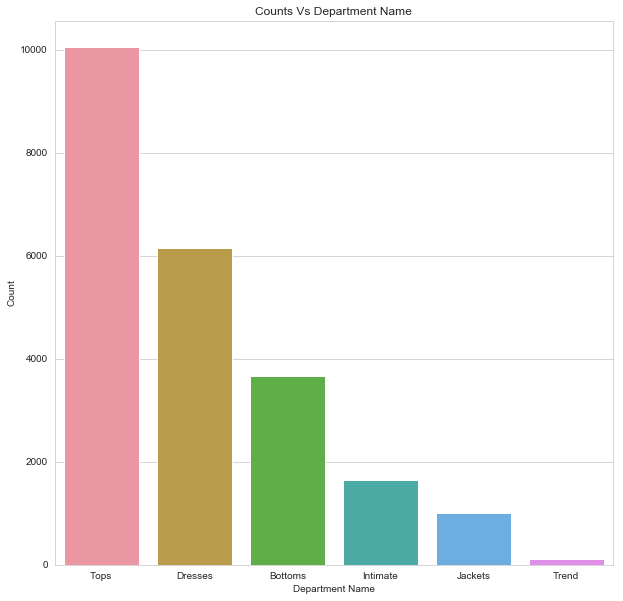

In [12]:
# Exploring Review counts per department
z = df.groupby(by=['Department Name'], as_index=False).count(
).sort_values(by='Class Name', ascending=False)

plt.figure(figsize=(10, 10))
sns.set_style("whitegrid")
ax = sns.barplot(x=z['Department Name'], y=z['Class Name'], data=z)
plt.xlabel("Department Name")
plt.ylabel("Count")
plt.title("Counts Vs Department Name")
plt.show()

Most of the reviews pertain to the Tops and Dresses departments.

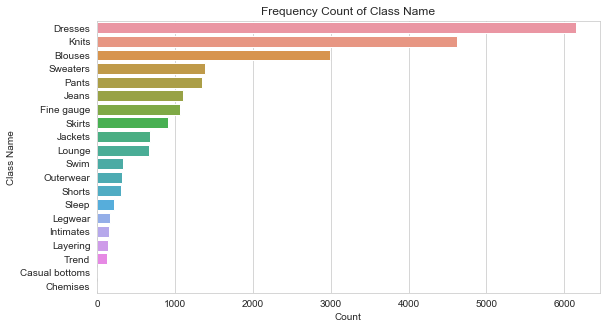

In [13]:
# Class Name Counts
plt.subplots(figsize=(9, 5))
sns.countplot(y="Class Name", data=df,
              order=df["Class Name"].value_counts().index)
plt.title("Frequency Count of Class Name")
plt.xlabel("Count")
plt.show()

We see that Dresses, Knits, and Blouses are the 3 most reviewed items, respectively.

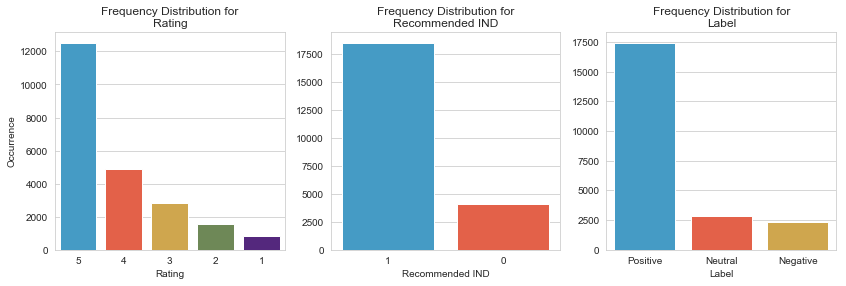

In [14]:
# Distribution of Rating, Recommended IND, and Label:
cat_dtypes = ["Rating", "Recommended IND", "Label"]
increment = 0
f, axes = plt.subplots(1, len(cat_dtypes), figsize=(14, 4), sharex=False)

for i in range(len(cat_dtypes)):
    sns.countplot(x=cat_dtypes[increment],
                  data=df,
                  order=df[cat_dtypes[increment
                                      ]].value_counts().index, ax=axes[i])
    axes[i].set_title(
        "Frequency Distribution for\n{}".format(cat_dtypes[increment]))
    axes[i].set_ylabel("Occurrence")
    axes[i].set_xlabel("{}".format(cat_dtypes[increment]))
    increment += 1
axes[1].set_ylabel("")
axes[2].set_ylabel("")
plt.show()

### Houston, we have a problem 

We see that the data is unevenly distributed. Overall the products are well rated, and are often recommended.

Later on I intend to perform machine learning on the data to determine whether reviews or review content is predictive of recommendation. As such, the class imbalance of the "Recommended IND" variable will pose a problem. For now, I won't normalize the data because I don't want to diminish the text corpus.

In [15]:
temp = (df.groupby('Clothing ID')[["Rating", "Recommended IND", "Age"]]
        .aggregate(['count', 'mean']))
temp.columns = ["Count", "Rating Mean", "Recommended IND Count",
                "Recommended Mean", "Age Count", "Age Mean"]

C:\Users\godwinz\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


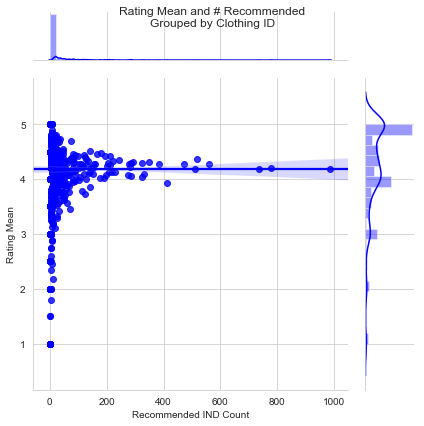

In [16]:
g = sns.jointplot(x="Recommended IND Count", y='Rating Mean', data=temp,
                  kind='reg', color='b')
plt.subplots_adjust(top=0.999)
g.fig.suptitle("Rating Mean and # Recommended\nGrouped by Clothing ID")
plt.tight_layout()
plt.show()

Lastly we see that the higher the mean rating, the more recommendations. While not exactly a grand revelation, we can also see that there are people we strongly liked the product, but nevertheless did not recommend it. 

## Cluster Analysis

I'll begin with some unsupervised feature exploration to determine if we need to use a supervised learning approach when we model later on.

### tfidf Vectorization 

Extracting features from the training dataset using a sparse vectorizer. I'm interested in whether or not the product was recommended. I'm going to use only the review text corpus to try to predict the rating, so first I'll need to vectorize my reviews. 

In [17]:
X = df.loc[:, 'Review Text']
y = df.loc[:, 'Recommended IND']
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

t0 = time()
vectorizer = TfidfVectorizer(max_df=0.5,
                             min_df=2, stop_words='english')

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.fit_transform(X_test)
print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X_train_tfidf.shape)
print()

done in 1.024800s
n_samples: 16971, n_features: 6955



### Truncated SVD and LSA
I needed to reduce the dimensionality of my sparse array, therefore I utilized truncated SVD and latent semantic analysis. Vectorizer results are normalized, which makes KMeans behave as spherical k-means for better results. Since LSA/SVD results are not normalized, we have to redo the normalization.

In [18]:
print("Performing dimensionality reduction using LSA")
t0 = time()

svd = TruncatedSVD(160)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X_train_lsa = lsa.fit_transform(X_train_tfidf)
X_test_lsa = lsa.fit_transform(X_test_tfidf)

print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

print()

Performing dimensionality reduction using LSA
done in 2.611000s
Explained variance of the SVD step: 36%



### k-means clustering
I want to try to cluster the data into distinct groups for each binary outcome.

In [19]:
# Since our target is boolean, we expect 2 clusters.
km = KMeans(n_clusters=2, max_iter=100,
            random_state=42)

print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X_train_lsa)
print("done in %0.3fs" % (time() - t0))
print()

Clustering sparse data with KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
done in 2.352s



In [20]:
km.cluster_centers_

array([[ 2.90131077e-01, -7.49831158e-02, -5.67453530e-03,
        -1.68283711e-02, -9.18173350e-03,  4.57751964e-03,
        -2.74350474e-03, -4.30952354e-03,  2.22405794e-04,
        -2.74925289e-03, -8.98724221e-03,  1.43307937e-03,
        -3.15397229e-04,  3.41585355e-03, -4.40603054e-03,
         2.94421398e-03, -1.16996247e-03,  5.93572988e-03,
        -5.74947159e-04, -1.68732348e-03,  1.52887160e-03,
        -3.13029889e-03,  4.27190981e-03, -3.20781775e-03,
         9.54355174e-04, -2.39366612e-03, -2.82128553e-04,
         1.27250724e-03, -3.94633858e-03, -6.73989897e-04,
         2.64289188e-03,  2.07462249e-03, -2.92086386e-03,
        -1.45624407e-03,  2.42533685e-03, -1.21029045e-03,
         9.58748625e-04,  3.72831451e-03, -5.56775363e-04,
        -3.16127817e-03, -4.49610327e-06,  3.39100250e-03,
         4.52939219e-04, -6.46206758e-04, -4.26348737e-03,
        -8.85591720e-04,  8.16741560e-04,  6.49475006e-04,
        -3.82878662e-03,  2.49316490e-03, -7.29599347e-0

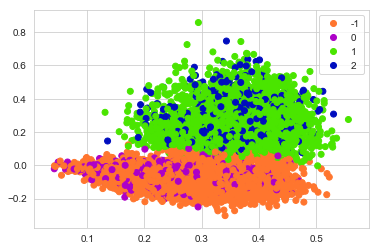


Confusion Matrix:  
 [[ 2332 10773]
 [  728  3138]]
   0:TN -1:FN 
   2:FP  1:TP
                    Classification Report 
               precision    recall  f1-score   support

           0       0.76      0.18      0.29     13105
           1       0.23      0.81      0.35      3866

   micro avg       0.32      0.32      0.32     16971
   macro avg       0.49      0.49      0.32     16971
weighted avg       0.64      0.32      0.30     16971



In [21]:
# Calculate predicted values.
y_pred = km.fit_predict(X_train_lsa)

# Calculate Error
y_error = (y_pred*2)-Y_train

#Define Error Colors
LABEL_COLOR_MAP = {-1: '#FF752E',
                   0:  '#ad00c8',
                   1: '#4ae500', 
                   2: '#000dbf'
                   }
label_color = [LABEL_COLOR_MAP[i] for i in y_error]

# Plot the solution.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=label_color) 
#Plot the error legend
markers = [
    plt.Line2D([0, 0], [0, 0], color=color,
               marker='o', linestyle=''
               ) for color in LABEL_COLOR_MAP.values()]
plt.legend(markers, LABEL_COLOR_MAP.keys(), numpoints=1)
plt.show()

# Check the solution against the data.
cm = confusion_matrix(y_pred, Y_train)
print("\nConfusion Matrix:  \n", cm)
print("   0:TN -1:FN \n   2:FP  1:TP")
print("                    Classification Report \n",
      classification_report(y_pred, Y_train))

Looks like this model isn't doing very well. We're correctly classifying 11,505 cases, but mis-classifying 5,466 of the cases! 

We can also see by the F1 score for 0 that we are very poorly predicting the "Not Recommended" outcome. There may be a better clustering algorithm for this data.

### MiniBatch K-Means:

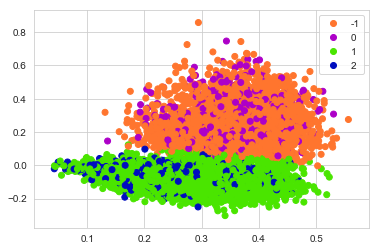

done in 1.259s
Confusion Matrix:  
 [[  760  3274]
 [ 2300 10637]]
   0:TN -1:FN 
   2:FP  1:TP
                    Classification Report 
               precision    recall  f1-score   support

           0       0.25      0.19      0.21      4034
           1       0.76      0.82      0.79     12937

   micro avg       0.67      0.67      0.67     16971
   macro avg       0.51      0.51      0.50     16971
weighted avg       0.64      0.67      0.65     16971



In [22]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=200)

# Timing the execution.
t0 = time()
minibatchkmeans.fit(X_train_lsa)

# Predictions
predict_mini = minibatchkmeans.predict(X_train_lsa)

# Error
mini_error = (predict_mini*2)-Y_train

# Error Color
LABEL_COLOR_MAP = {-1: '#FF752E',
                   0:  '#ad00c8',
                   1: '#4ae500', 
                   2: '#000dbf'
                   }
label_color = [LABEL_COLOR_MAP[i] for i in mini_error]

# Plot the solution.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=label_color)
# Plot the legend
markers = [
    plt.Line2D([0, 0], [0, 0], color=color,
               marker='o', linestyle=''
               ) for color in LABEL_COLOR_MAP.values()]
plt.legend(markers, LABEL_COLOR_MAP.keys(), numpoints=1)
plt.show()

print("done in %0.3fs" % (time() - t0))

# Check the MiniBatch model against our earlier one.
cm = confusion_matrix(predict_mini, Y_train)
print("Confusion Matrix:  \n", cm)
print("   0:TN -1:FN \n   2:FP  1:TP")
print("                    Classification Report \n",
      classification_report(predict_mini, Y_train))

With MiniBatch we're correctly classifying 7,899 cases, but mis-classifying 9,072 of the cases! MiniBatch may be quicker, but it performs much worse on this data. 

### Mean Shift

In [23]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train_lsa, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_lsa)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 1


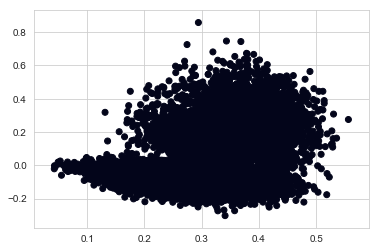

Comparing the assigned categories to the ones in the data:
Confusion Matrix:  
 [[ 3060 13911]
 [    0     0]]
   0:TN -1:FN 
   2:FP  1:TP
                    Classification Report 
               precision    recall  f1-score   support

           0       0.25      0.19      0.21      4034
           1       0.76      0.82      0.79     12937

   micro avg       0.67      0.67      0.67     16971
   macro avg       0.51      0.51      0.50     16971
weighted avg       0.64      0.67      0.65     16971



In [24]:
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
cm = confusion_matrix(labels, Y_train)
print("Confusion Matrix:  \n", cm)
print("   0:TN -1:FN \n   2:FP  1:TP")
print("                    Classification Report \n",
      classification_report(predict_mini, Y_train))

Mean Shift underestimates the number of clusters, making it not very useful for this data. We're mis-classifying 13,911 cases as not recommended and are not classifying any as recommended.
### Spectral Clustering

In [26]:
# We know we're looking for 2 clusters.
n_clusters = 2

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
t0 = time()
sc.fit(X_train_lsa)
print("done in %0.3fs" % (time() - t0))

# Predicted clusters.
sc_predict = sc.fit_predict(X_train_lsa)

# Error
y_error_sc = (sc_predict*2)-Y_train

# Error Color
LABEL_COLOR_MAP = {-1: '#FF752E',
                   0:  '#ad00c8',
                   1: '#4ae500',  # "#d63900"',
                   2: '#000dbf'
                   }
label_color = [LABEL_COLOR_MAP[i] for i in mini_error]

# Plot results.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=label_color)

# Plot Error Legend
markers = [
    plt.Line2D([0, 0], [0, 0], color=color,
               marker='o', linestyle=''
               ) for color in LABEL_COLOR_MAP.values()]
plt.legend(markers, LABEL_COLOR_MAP.keys(), numpoints=1)
plt.show()

# Check the Spectral Cluster model against the data.
cm = confusion_matrix(sc_predict, Y_train)
print("Confusion Matrix:  \n", cm)
print("   0:TN -1:FN \n   2:FP  1:TP")
print("                    Classification Report \n",
      classification_report(predict_mini, Y_train))

MemoryError: 

With spectral clustering, we're correctly classifying 11,694 cases, but mis-classifying 5,277 of the cases! K-Means classifies with much less error.

### TSNE

In [35]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
t0 = time()
tsne_results = tsne.fit_transform(X_train_lsa)
print("done in %0.3fs" % (time() - t0))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 16971 samples in 0.143s...
[t-SNE] Computed neighbors for 16971 samples in 94.406s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16971
[t-SNE] Computed conditional probabilities for sample 2000 / 16971
[t-SNE] Computed conditional probabilities for sample 3000 / 16971
[t-SNE] Computed conditional probabilities for sample 4000 / 16971
[t-SNE] Computed conditional probabilities for sample 5000 / 16971
[t-SNE] Computed conditional probabilities for sample 6000 / 16971
[t-SNE] Computed conditional probabilities for sample 7000 / 16971
[t-SNE] Computed conditional probabilities for sample 8000 / 16971
[t-SNE] Computed conditional probabilities for sample 9000 / 16971
[t-SNE] Computed conditional probabilities for sample 10000 / 16971
[t-SNE] Computed conditional probabilities for sample 11000 / 16971
[t-SNE] Computed conditional probabilities for sample 12000 / 16971
[t-SNE] Computed conditional probabilities for s

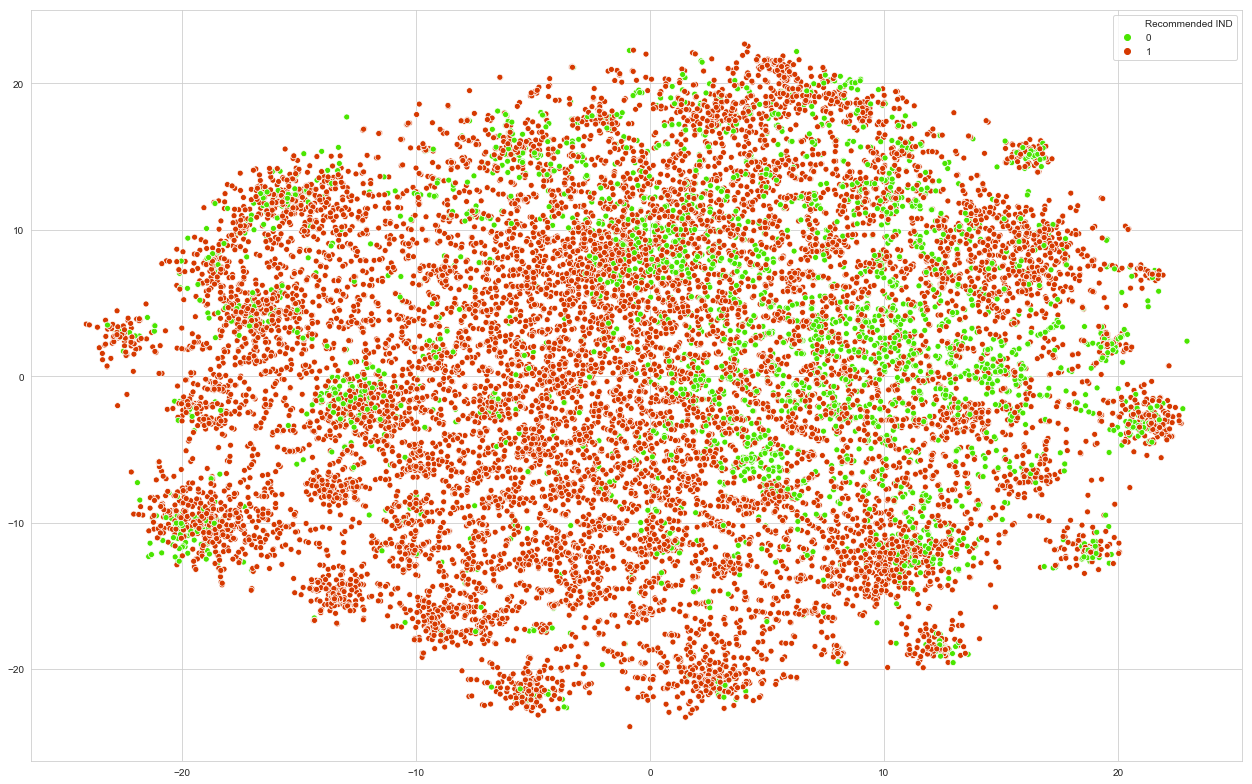

In [36]:
a4_dims = (17.5, 11)
fig, ax = plt.subplots(figsize=a4_dims)
flatui = ["#4ae500", "#d63900"]
order = [0, 1]

sns.scatterplot(tsne_results[:, 0], tsne_results[:, 1],
                hue=Y_train, palette=flatui,
                hue_order=order,
                ax=ax)
plt.tight_layout()

TSNE converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. We can color the data by the true outcome variable and we how similar reviews that led to a recommendation are to those that did not. 

Since this clustering algorithm is clustering the reviews relative to each other, and coloring by the true outcome I feel that this is the best clustering algorithm of those tested. The high degree of error for the others make them less useful.

In [37]:
# Clustering the test data
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
t0 = time()
tsne_results = tsne.fit_transform(X_test_lsa)
print("done in %0.3fs" % (time() - t0))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5657 samples in 0.034s...
[t-SNE] Computed neighbors for 5657 samples in 8.667s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5657
[t-SNE] Computed conditional probabilities for sample 2000 / 5657
[t-SNE] Computed conditional probabilities for sample 3000 / 5657
[t-SNE] Computed conditional probabilities for sample 4000 / 5657
[t-SNE] Computed conditional probabilities for sample 5000 / 5657
[t-SNE] Computed conditional probabilities for sample 5657 / 5657
[t-SNE] Mean sigma: 0.292330
[t-SNE] KL divergence after 50 iterations with early exaggeration: 87.507271
[t-SNE] KL divergence after 300 iterations: 3.250774
done in 22.151s


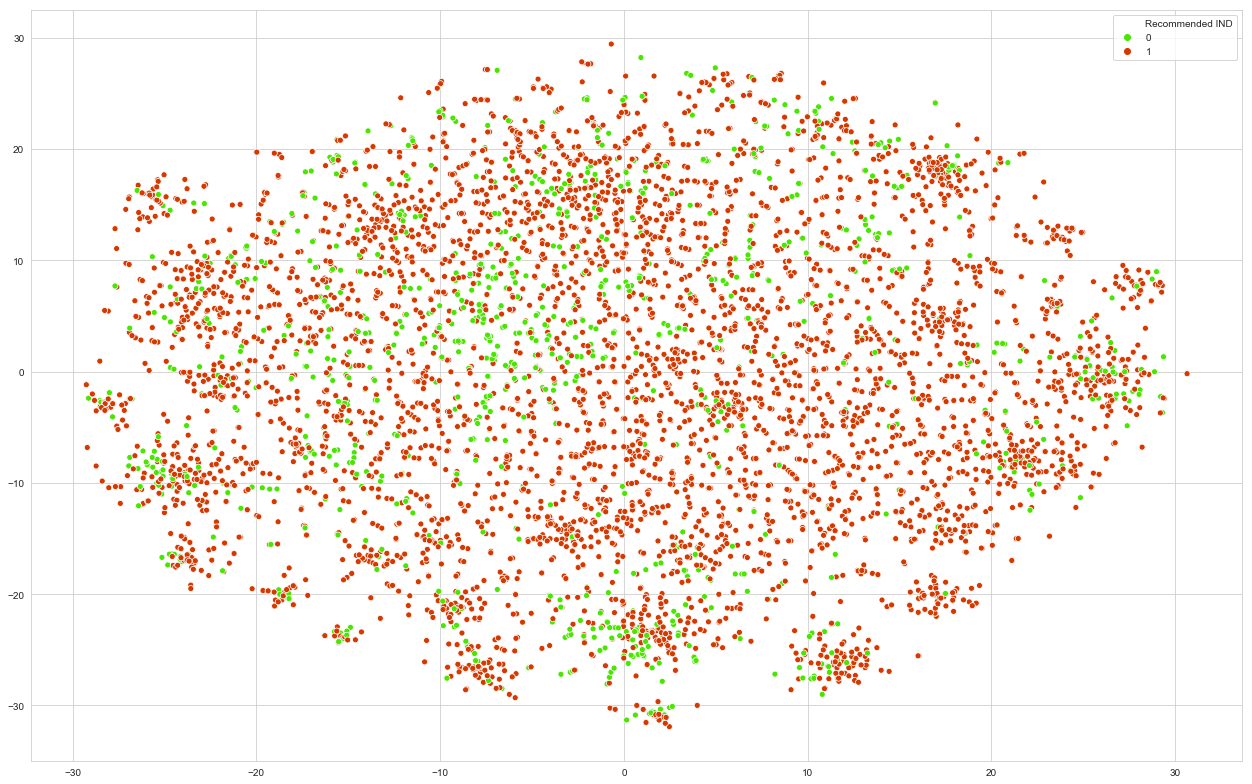

In [39]:
a4_dims = (17.5, 11)
fig, ax = plt.subplots(figsize=a4_dims)
flatui = ["#4ae500", "#d63900"]
order = [0, 1]

sns.scatterplot(tsne_results[:, 0], tsne_results[:, 1],
                hue=Y_test, palette=flatui,
                hue_order=order,
                ax=ax)
plt.tight_layout()

When we compare the TSNE clustering of the training set to that of the hold back group, we see similar diffuse coloration. This tells us that the training set and test set cluster similarly.

It would seem that there isn't a strong similarity in the entire review. We can instead investigate the key words using NLP techniques such as tokenization and lemmatization. We may find that while the entire review doesn't cluster around our target, the key words may.

## NLP Reviews Into Weighted Word Counts

In [27]:
# Importing SKLearn's list of stopwords and 
# then appending with my own words
stop = text.ENGLISH_STOP_WORDS

# Basic text cleaning function
def remove_noise(text):

    # Make lowercase
    text = text.apply(lambda x: " ".join(x.lower() for x in x.split()))

    # Remove whitespaces
    text = text.apply(lambda x: " ".join(x.strip() for x in x.split()))

    # Remove special characters
    text = text.apply(lambda x: "".join(
        [" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))

    # Remove punctuation
    text = text.str.replace('[^\w\s]', '')

    # Remove numbers
    text = text.str.replace('\d+', '')

    # Remove Stopwords
    text = text.apply(lambda x: ' '.join(
        [word for word in x.split() if word not in (stop)]))

    # Convert to string
    text = text.astype(str)

    return text


# Applying noise removal function to data
df['Filtered Review Text'] = remove_noise(df['Review Text'])
df.head(5)

Clothing ID  Age                    Title  \
0          767   33                      NaN   
1         1080   34                      NaN   
2         1077   60  Some major design flaws   
3         1049   50         My favorite buy!   
4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  \
0                        0       Initmates        Intimate  Intimates   
1                        4         General         Dresses    Dresses   
2                        0         General         Dresses    Dresses   
3                        0  General Petite         Bottoms      Pants   
4                        6         General            Tops    Blouses   

   Word Count  Character Count     Label  \
0           8               53  Positive   
1          62              303  Positive   
2          98              500   Neutral   
3          22              124  Positive   
4          36              192  Positive   

                                Filtered Review Text  
0        absolutely wonderful silky sexy comfortable  
1  love dress sooo pretty happened store im glad ...  
2  high hopes dress really wanted work initially ...  
3  love love love jumpsuit fun flirty fabulous ti...  
4  shirt flattering adjustable tie perfect length...

### Tokenization and Lemmatization
Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces. A token is an instance of a sequence of characters in some particular document that are grouped together as a useful semantic unit for processing.

The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

My hope is that by processing down the text to these unique tokens and lemmas we'll be able to accurately build predictive models.

In [28]:
# Instantiate the Word tokenizer & Word lemmatizer
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# Define a word lemmatizer function
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]


# Apply the word lemmatizer function to data
df['Filtered Review Text Lemmas'] = df['Filtered Review Text'].apply(
    lemmatize_text)
df.head()

LookupError: 
**********************************************************************
  Resource [93mwordnet[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('wordnet')
  [0m
  Attempted to load [93mcorpora/wordnet[0m

  Searched in:
    - 'C:\\Users\\godwinz/nltk_data'
    - 'C:\\Users\\godwinz\\AppData\\Local\\Continuum\\anaconda3\\nltk_data'
    - 'C:\\Users\\godwinz\\AppData\\Local\\Continuum\\anaconda3\\share\\nltk_data'
    - 'C:\\Users\\godwinz\\AppData\\Local\\Continuum\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\godwinz\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [43]:
# Getting a count of lemmas from the documents
# Ngram_range is set to 1,2 - meaning either single or two word 
# combinations will be extracted
cvec = CountVectorizer(min_df=.005, max_df=.9, ngram_range=(1, 2),
                       tokenizer=lambda doc: doc, lowercase=False)
cvec.fit(df['Filtered Review Text Lemmas'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.9, max_features=None, min_df=0.005,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function <lambda> at 0x0000025326F49598>,
        vocabulary=None)

In [44]:
# Getting the total n-gram count
len(cvec.vocabulary_)

908

### Bag of Words

I want to further reduce my reviews down to a simpler bag of words representation of the text. We'll use these to build features for training the classification models.

In [46]:
# Creating the bag-of-words representation
cvec_counts = cvec.transform(df['Filtered Review Text Lemmas'])
print('sparse matrix shape:', cvec_counts.shape)
print('nonzero count:', cvec_counts.nnz)
print('sparsity: %.2f%%' % (
    100.0 * cvec_counts.nnz / (cvec_counts.shape[0] * cvec_counts.shape[1])))

sparse matrix shape: (22628, 908)
nonzero count: 474877
sparsity: 2.31%


In [47]:
# Instantiating the TfidfTransformer
transformer = TfidfTransformer()

# Fitting and transforming n-grams
transformed_weights = transformer.fit_transform(cvec_counts)
transformed_weights

<22628x908 sparse matrix of type '<class 'numpy.float64'>'
	with 474877 stored elements in Compressed Sparse Row format>

In [48]:
# Getting a list of all n-grams
transformed_weights_array = transformed_weights.toarray()
vocab = cvec.get_feature_names()

# Putting weighted n-grams into a DataFrame and 
# computing some summary statistics
weighted_ngrams = pd.DataFrame(transformed_weights_array, columns=vocab)
weighted_ngrams['Keyword'] = weighted_ngrams.idxmax(axis=1)
weighted_ngrams['Max'] = weighted_ngrams.max(axis=1)
weighted_ngrams['Sum'] = weighted_ngrams.drop('Max', axis=1).sum(axis=1)
weighted_ngrams.head(10)

able  absolutely  absolutely love  actually  add  added  addition  \
0   0.0    0.384328              0.0       0.0  0.0    0.0       0.0   
1   0.0    0.000000              0.0       0.0  0.0    0.0       0.0   
2   0.0    0.000000              0.0       0.0  0.0    0.0       0.0   
3   0.0    0.000000              0.0       0.0  0.0    0.0       0.0   
4   0.0    0.000000              0.0       0.0  0.0    0.0       0.0   
5   0.0    0.000000              0.0       0.0  0.0    0.0       0.0   
6   0.0    0.000000              0.0       0.0  0.0    0.0       0.0   
7   0.0    0.000000              0.0       0.0  0.0    0.0       0.0   
8   0.0    0.000000              0.0       0.0  0.0    0.0       0.0   
9   0.0    0.000000              0.0       0.0  0.0    0.0       0.0   

   adorable  adore  afraid    ...     year  yellow  yes  yesterday     youre  \
0       0.0    0.0     0.0    ...      0.0     0.0  0.0        0.0  0.000000   
1       0.0    0.0     0.0    ...      0.0     0.0  0.0        0.0  0.000000   
2       0.0    0.0     0.0    ...      0.0     0.0  0.0        0.0  0.000000   
3       0.0    0.0     0.0    ...      0.0     0.0  0.0        0.0  0.000000   
4       0.0    0.0     0.0    ...      0.0     0.0  0.0        0.0  0.000000   
5       0.0    0.0     0.0    ...      0.0     0.0  0.0        0.0  0.000000   
6       0.0    0.0     0.0    ...      0.0     0.0  0.0        0.0  0.000000   
7       0.0    0.0     0.0    ...      0.0     0.0  0.0        0.0  0.000000   
8       0.0    0.0     0.0    ...      0.0     0.0  0.0        0.0  0.000000   
9       0.0    0.0     0.0    ...      0.0     0.0  0.0        0.0  0.179038   

        zip    zipper     Keyword       Max       Sum  
0  0.000000  0.000000       silky  0.548700  2.180334  
1  0.000000  0.000000          bc  0.462192  4.592337  
2  0.178653  0.156816       layer  0.450171  5.222070  
3  0.000000  0.000000   love love  0.648354  2.698862  
4  0.000000  0.000000       shirt  0.442404  3.275608  
5  0.000000  0.000000       dress  0.383198  4.747349  
6  0.000000  0.000000      trying  0.515442  4.143620  
7  0.000000  0.000000        went  0.334111  4.851432  
8  0.000000  0.000000  run little  0.334538  4.096254  
9  0.000000  0.000000           s  0.295521  5.904906  

[10 rows x 911 columns]

### Another run at TSNE

In [49]:
X2 = weighted_ngrams.loc[:, ['Sum'] + ['Max']]

Let's try clustering the sum and max weighted n-grams in TSNE and see if the clusters are more defined.

In [50]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
t0 = time()
tsne_results = tsne.fit_transform(X2)
print("done in %0.3fs" % (time() - t0))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 22628 samples in 0.007s...
[t-SNE] Computed neighbors for 22628 samples in 0.428s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22628
[t-SNE] Computed conditional probabilities for sample 2000 / 22628
[t-SNE] Computed conditional probabilities for sample 3000 / 22628
[t-SNE] Computed conditional probabilities for sample 4000 / 22628
[t-SNE] Computed conditional probabilities for sample 5000 / 22628
[t-SNE] Computed conditional probabilities for sample 6000 / 22628
[t-SNE] Computed conditional probabilities for sample 7000 / 22628
[t-SNE] Computed conditional probabilities for sample 8000 / 22628
[t-SNE] Computed conditional probabilities for sample 9000 / 22628
[t-SNE] Computed conditional probabilities for sample 10000 / 22628
[t-SNE] Computed conditional probabilities for sample 11000 / 22628
[t-SNE] Computed conditional probabilities for sample 12000 / 22628
[t-SNE] Computed conditional probabilities for sa

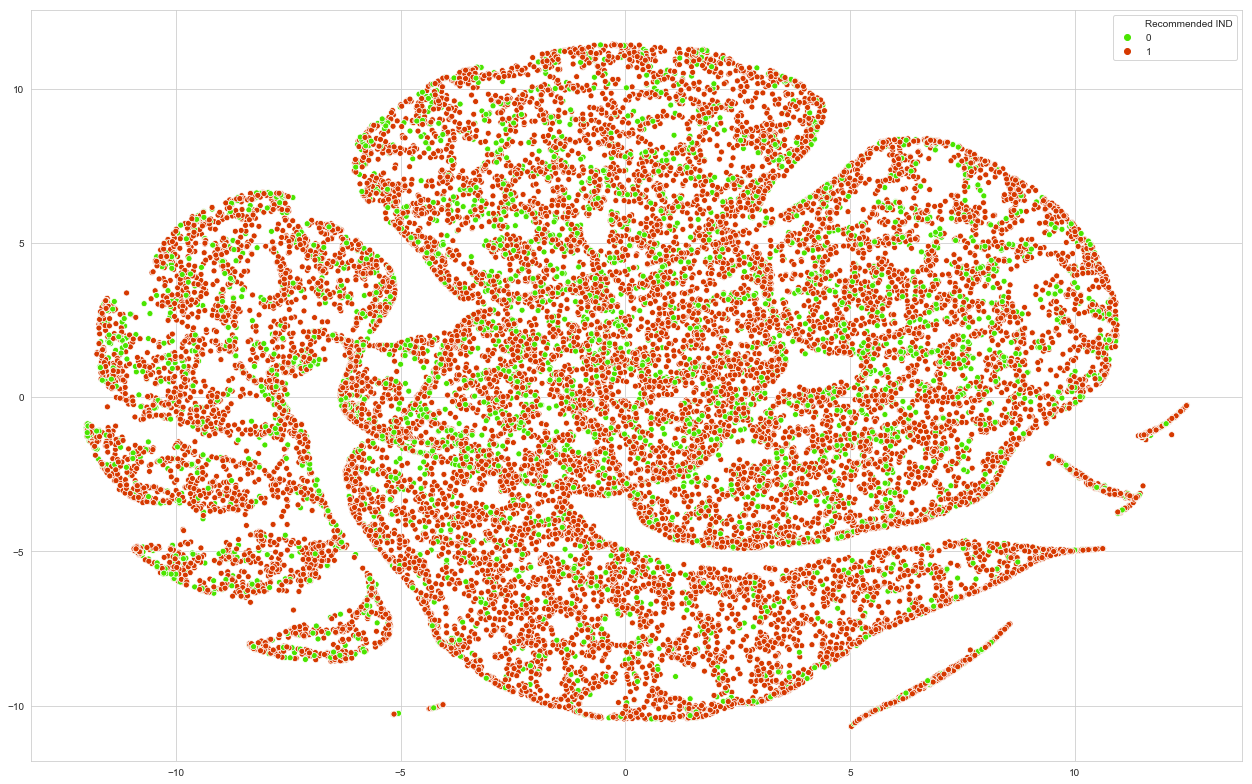

In [51]:
a4_dims = (17.5, 11)
fig, ax = plt.subplots(figsize=a4_dims)
flatui = ["#4ae500", "#d63900"]
order = [0, 1]


sns.scatterplot(tsne_results[:, 0], tsne_results[:, 1],
                hue=y, palette=flatui,
                hue_order=order,
                ax=ax)
plt.tight_layout()

In [52]:
# Joining my dataframes in preperation for machine learning.
df2 = pd.merge(df, weighted_ngrams, left_index=True, right_index=True)
df2.head()

Clothing ID  Age                    Title  \
0          767   33                      NaN   
1         1080   34                      NaN   
2         1077   60  Some major design flaws   
3         1049   50         My favorite buy!   
4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  \
0                        0       Initmates        Intimate  Intimates   
1                        4         General         Dresses    Dresses   
2                        0         General         Dresses    Dresses   
3                        0  General Petite         Bottoms      Pants   
4                        6         General            Tops    Blouses   

     ...     year  yellow  yes yesterday youre       zip    zipper    Keyword  \
0    ...      0.0     0.0  0.0       0.0   0.0  0.000000  0.000000      silky   
1    ...      0.0     0.0  0.0       0.0   0.0  0.000000  0.000000         bc   
2    ...      0.0     0.0  0.0       0.0   0.0  0.178653  0.156816      layer   
3    ...      0.0     0.0  0.0       0.0   0.0  0.000000  0.000000  love love   
4    ...      0.0     0.0  0.0       0.0   0.0  0.000000  0.000000      shirt   

        Max       Sum  
0  0.548700  2.180334  
1  0.462192  4.592337  
2  0.450171  5.222070  
3  0.648354  2.698862  
4  0.442404  3.275608  

[5 rows x 926 columns]

### Comparing Word Frequency to Weight

In [53]:
# Getting a view of the top 20 occurring words
occ = np.asarray(cvec_counts.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'Term': cvec.get_feature_names(),
                          'Occurrences': occ})
counts_df.sort_values(by='Occurrences', ascending=False).head(25)

Term  Occurrences
179        dress        11320
241          fit        10093
682         size         9353
450         love         8962
412         like         7017
112        color         6902
436         look         6872
857         wear         6507
295        great         6073
347           im         5987
372         just         5568
218       fabric         4843
708        small         4571
598       really         3921
523      ordered         3831
424       little         3769
546      perfect         3730
258   flattering         3484
716         soft         3302
120  comfortable         3029
142         cute         3018
499         nice         3008
68        bought         2981
43     beautiful         2936
55           bit         2874

In [54]:
# Getting a view of the top 20 weights
weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'Term': cvec.get_feature_names(),
                           'Weight': weights})
weights_df.sort_values(by='Weight', ascending=False).head(25)

Term    Weight
179        dress  0.052436
450         love  0.042386
241          fit  0.041355
682         size  0.039730
295        great  0.034190
112        color  0.034026
436         look  0.033117
412         like  0.032630
857         wear  0.031710
347           im  0.028924
372         just  0.028183
218       fabric  0.026683
708        small  0.024966
546      perfect  0.023226
598       really  0.022726
424       little  0.022330
258   flattering  0.022295
120  comfortable  0.021749
142         cute  0.021537
716         soft  0.021511
523      ordered  0.021352
666        shirt  0.020508
43     beautiful  0.020212
499         nice  0.019664
759      sweater  0.019572

We can note that the occurrence count deviates from the term weight.

### WordCloud Visualization 

In [75]:
# read the mask image taken from
mask = np.array(Image.open("Dress.png"))


def wc(data, bgcolor, title):
    plt.figure(figsize=(100, 100))
    wc = WordCloud(background_color=bgcolor, max_words=1000,
                   mask=mask, max_font_size=50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')


wordlist = counts_df['Term']
wordlist2 = weights_df['Term']

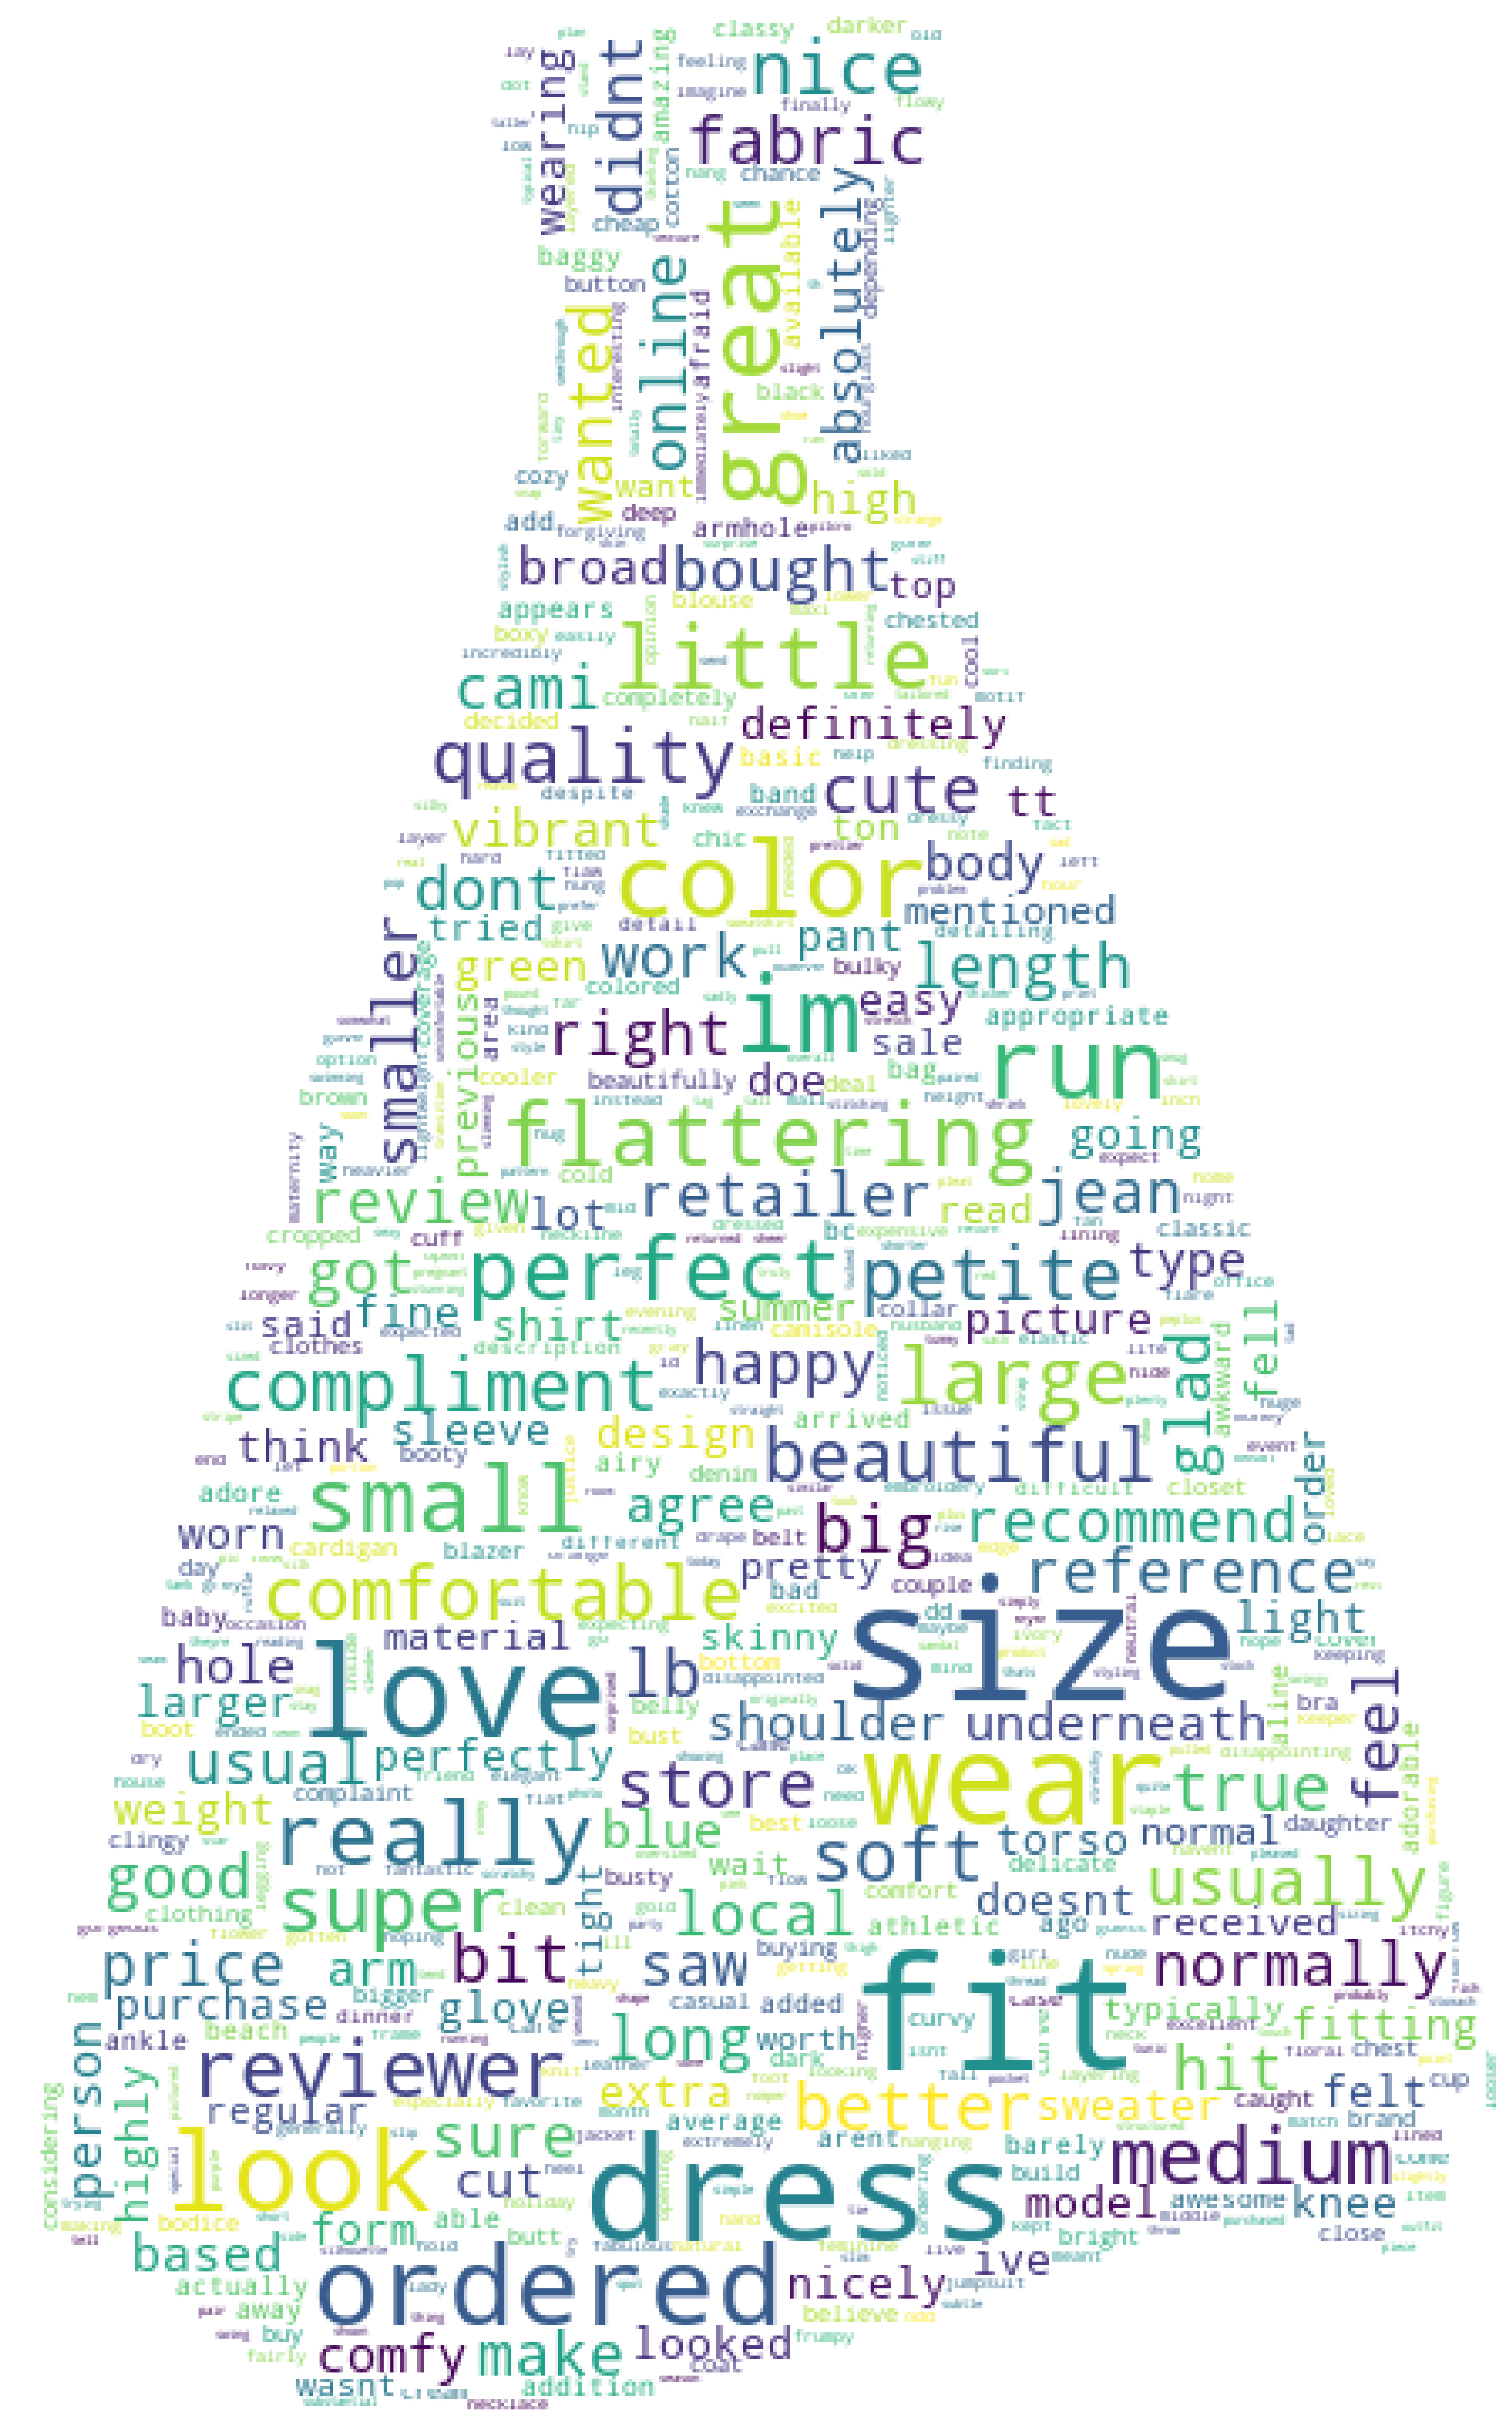

In [85]:
wc(wordlist, 'white', 'Most Used Words',)

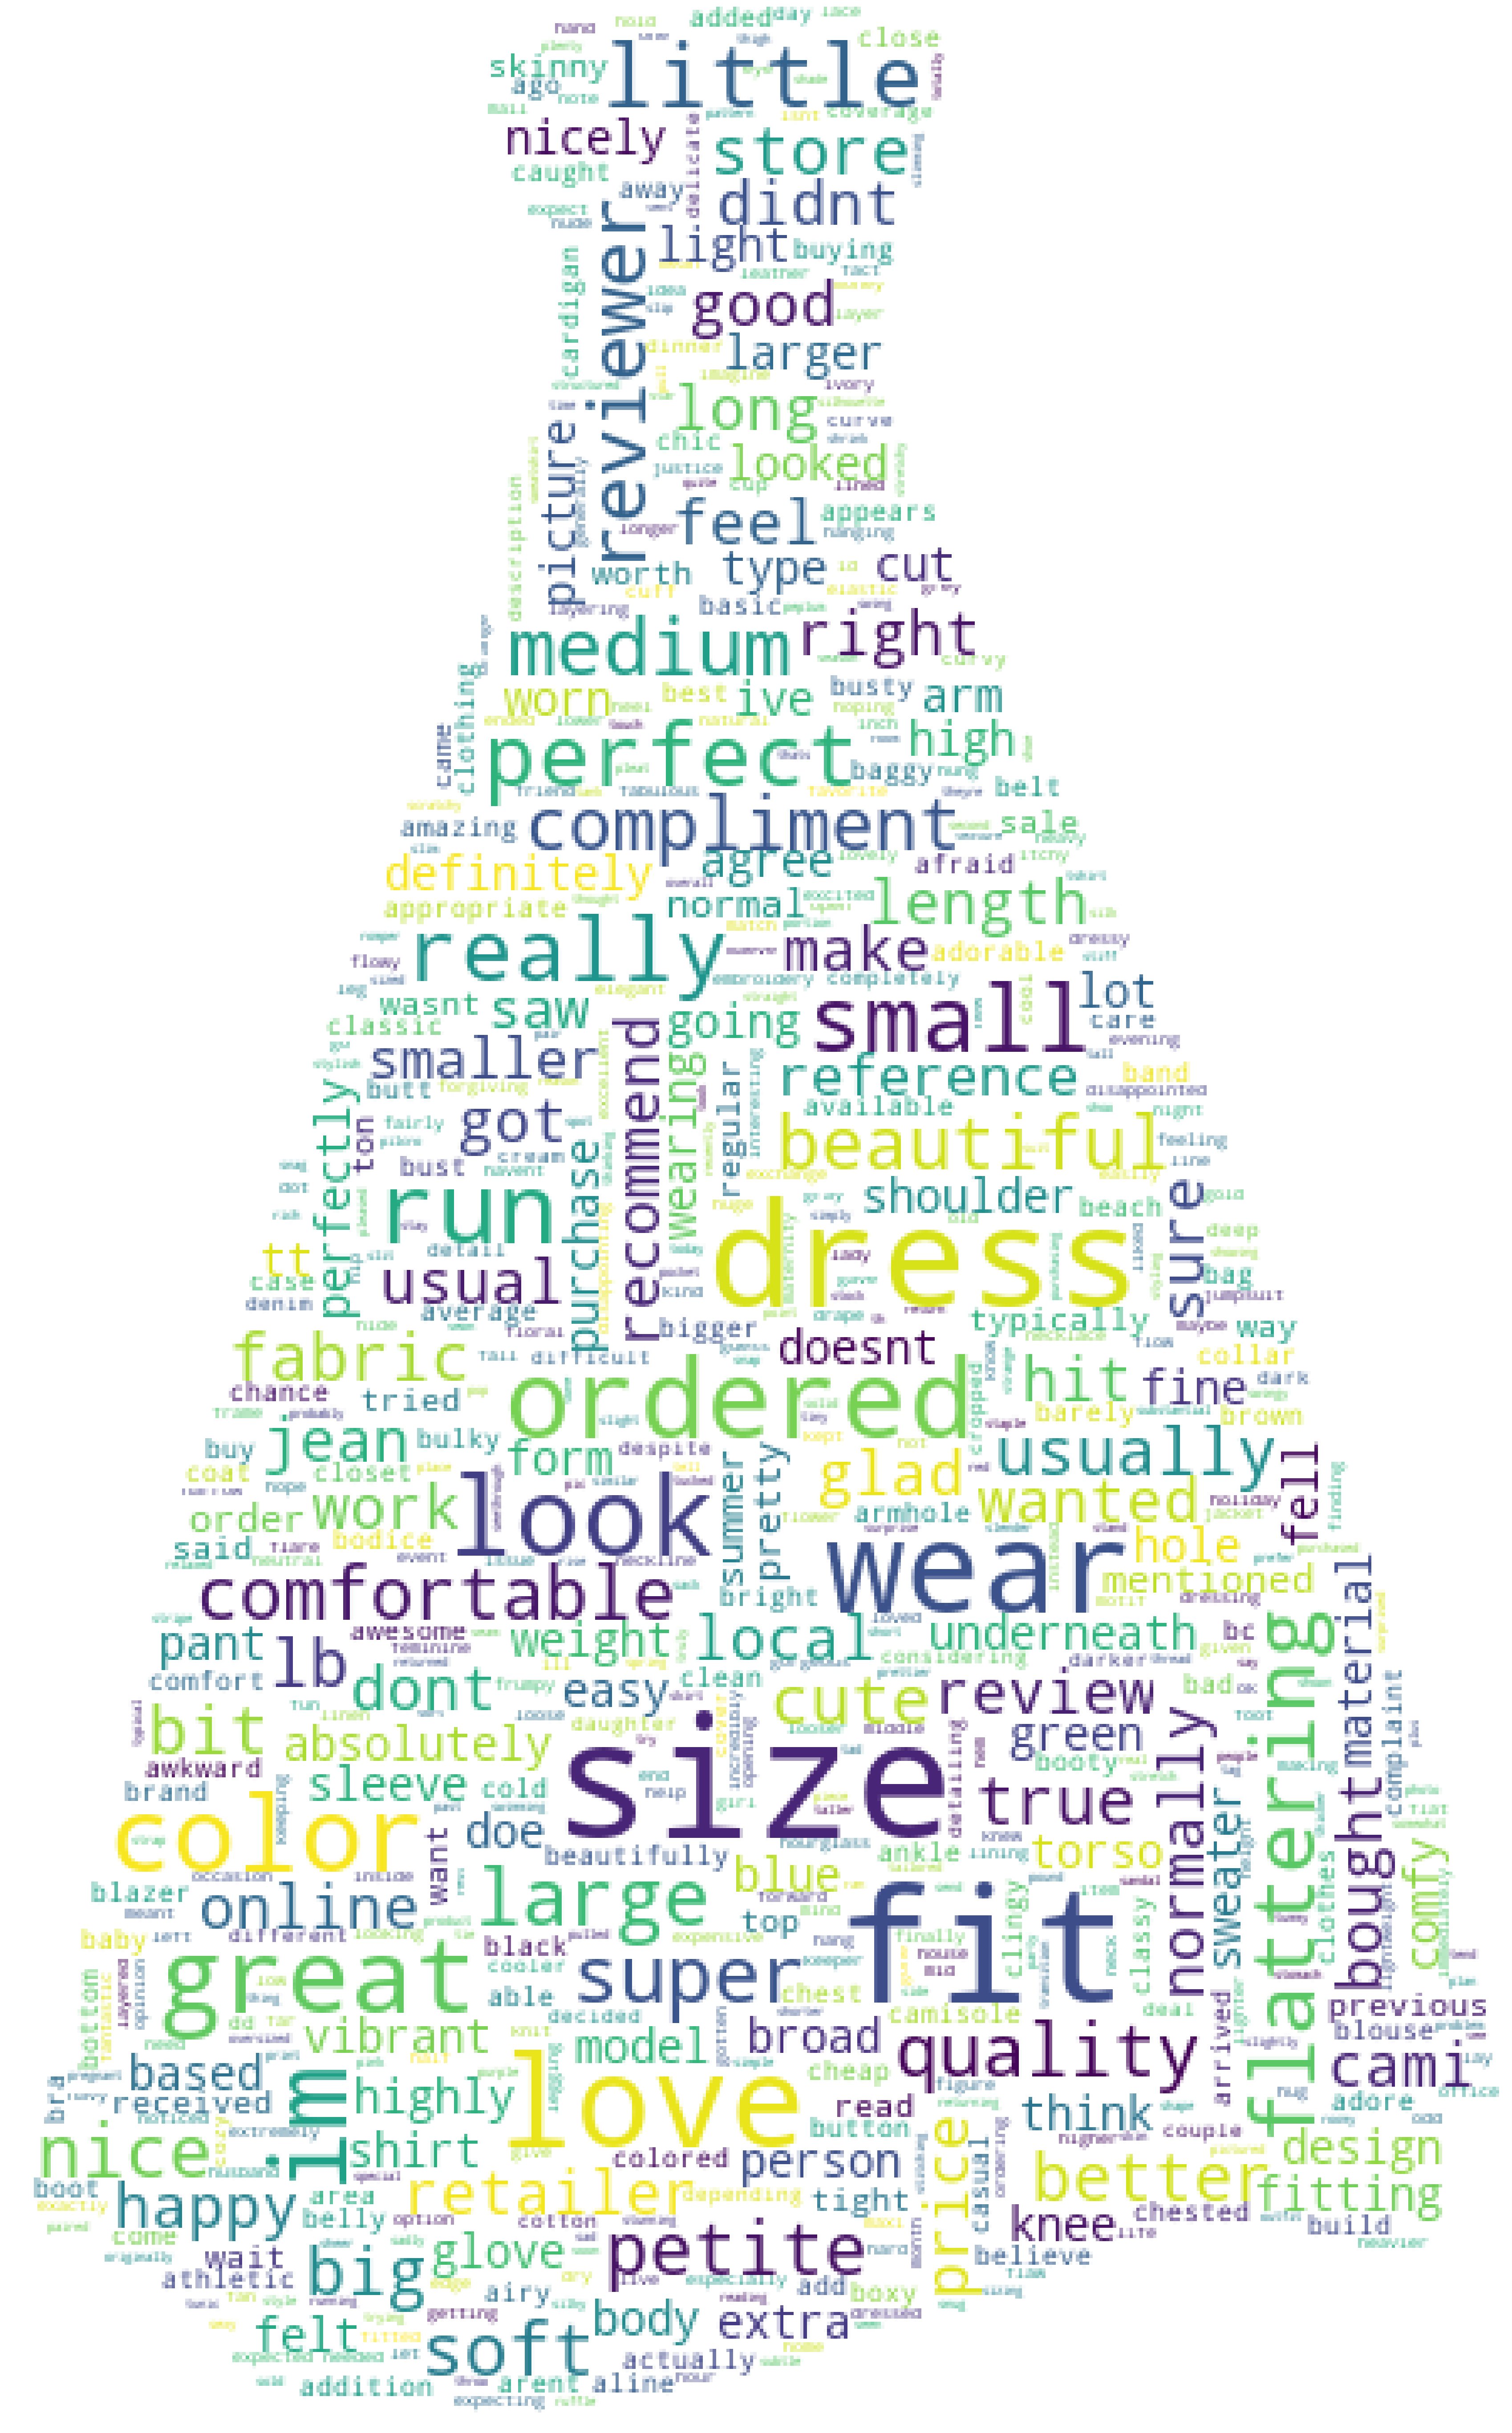

In [82]:
wc(wordlist2, 'white', 'Most Used Words',)

This gives a fun visual representation of the previous table. And since dressed were the biggest contributor to the data, it only felt appropriate to use a dress as our WordCloud stencil!

## Machine Learning
We'll perform Supervised Machine Learning to determine if features we created with Bag of Words are predictive of Recommendations. 

### Establishing training data

In [94]:
# Drop all columns not part of the text matrix and store as a copy of df2.
df2 = df2.drop(['Age', 'Title', 'Rating', 'Positive Feedback Count',
                     'Division Name', 'Department Name', 'Class Name', 
                     'Word Count', 'Character Count', 'Clothing ID', 
                     'Review Text', 'Keyword', 'Max', 'Sum',
                      'Filtered Review Text', 'Filtered Review Text Lemmas', 
                     'Label'], axis=1)
                      

# Create X & y variables for Machine Learning
X_ml = ml_model.drop('Recommended IND', axis=1)
y_ml = ml_model['Recommended IND']

# Create a train-test split of these modeling variables
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_ml, y_ml, test_size=0.25, random_state=42)

In [95]:
# Sanity Check
ml_model.head()

Recommended IND  able  absolutely  absolutely love  actually  add  added  \
0                1   0.0    0.384328              0.0       0.0  0.0    0.0   
1                1   0.0    0.000000              0.0       0.0  0.0    0.0   
2                0   0.0    0.000000              0.0       0.0  0.0    0.0   
3                1   0.0    0.000000              0.0       0.0  0.0    0.0   
4                1   0.0    0.000000              0.0       0.0  0.0    0.0   

   addition  adorable  adore    ...     x s   xl   xx  year  yellow  yes  \
0       0.0       0.0    0.0    ...     0.0  0.0  0.0   0.0     0.0  0.0   
1       0.0       0.0    0.0    ...     0.0  0.0  0.0   0.0     0.0  0.0   
2       0.0       0.0    0.0    ...     0.0  0.0  0.0   0.0     0.0  0.0   
3       0.0       0.0    0.0    ...     0.0  0.0  0.0   0.0     0.0  0.0   
4       0.0       0.0    0.0    ...     0.0  0.0  0.0   0.0     0.0  0.0   

   yesterday  youre       zip    zipper  
0        0.0    0.0  0.000000  0.000000  
1        0.0    0.0  0.000000  0.000000  
2        0.0    0.0  0.178653  0.156816  
3        0.0    0.0  0.000000  0.000000  
4        0.0    0.0  0.000000  0.000000  

[5 rows x 909 columns]

### Automating model testing

In [96]:
# Defining a function to fit and predict ML algorithms
def auto_model(mod, model_name, X_train_ml, X_test_ml, y_train_ml, y_test_ml):
    mod.fit(X_train_ml, y_train_ml)
    print(model_name)
    acc = cross_val_score(mod, X_train_ml, y_train_ml,
                          scoring="accuracy", cv=5)
    predictions = cross_val_predict(mod, X_train_ml, y_train_ml, cv=5)
    print("Accuracy:", round(acc.mean(), 3))
    cm = confusion_matrix(predictions, y_train_ml)
    print("Confusion Matrix:  \n", cm)
    print("                    Classification Report \n",
          classification_report(predictions, y_train_ml))

### Naive Bayes Classification

In [97]:
# Gaussian Naive Bayes
gnb = GaussianNB()
auto_model(gnb, "Gaussian Naive Bayes",
           X_train_ml, X_test_ml, y_train_ml, y_test_ml)

Gaussian Naive Bayes
Accuracy: 0.546
Confusion Matrix:  
 [[1387 5890]
 [1539 7532]]
                    Classification Report 
               precision    recall  f1-score   support

           0       0.47      0.19      0.27      7277
           1       0.56      0.83      0.67      9071

   micro avg       0.55      0.55      0.55     16348
   macro avg       0.52      0.51      0.47     16348
weighted avg       0.52      0.55      0.49     16348



Not the greatest model. Low Accuracy and pretty undesirable f1-scores.
### Random Forest Classification

In [98]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=50)
auto_model(rfc, "Random Forest Classifier",
           X_train_ml, X_test_ml, y_train_ml, y_test_ml)

Random Forest Classifier
Accuracy: 0.817
Confusion Matrix:  
 [[   10    53]
 [ 2916 13369]]
                    Classification Report 
               precision    recall  f1-score   support

           0       0.00      0.16      0.01        63
           1       1.00      0.82      0.90     16285

   micro avg       0.82      0.82      0.82     16348
   macro avg       0.50      0.49      0.45     16348
weighted avg       0.99      0.82      0.90     16348



Still not the greatest model. Accuracy is much improved but we can see there is something going on with it's ability to predict "Not Recommended" - the f1 score is 0.01! 
### Logistic Regression

In [99]:
# Logistic Regression
log = LogisticRegression(solver='lbfgs')
auto_model(log, "Logistic Regression",
           X_train_ml, X_test_ml, y_train_ml, y_test_ml)

Logistic Regression
Accuracy: 0.821
Confusion Matrix:  
 [[    1     0]
 [ 2925 13422]]
                    Classification Report 
               precision    recall  f1-score   support

           0       0.00      1.00      0.00         1
           1       1.00      0.82      0.90     16347

   micro avg       0.82      0.82      0.82     16348
   macro avg       0.50      0.91      0.45     16348
weighted avg       1.00      0.82      0.90     16348



Hmmm...the model performs similarly to the Random Forest Classifier. Whatever the issue is, it impacts both models. 
### Linear SVC

In [100]:
# Linear SVC
svc = LinearSVC()
auto_model(svc, "Linear SVC",
           X_train_ml, X_test_ml, y_train_ml, y_test_ml)

Linear SVC
Accuracy: 0.82
Confusion Matrix:  
 [[    3    14]
 [ 2923 13408]]
                    Classification Report 
               precision    recall  f1-score   support

           0       0.00      0.18      0.00        17
           1       1.00      0.82      0.90     16331

   micro avg       0.82      0.82      0.82     16348
   macro avg       0.50      0.50      0.45     16348
weighted avg       1.00      0.82      0.90     16348



### Model Comparison 

Ok now we're 4/4 for models having inability to predict "Not Recommended". I have some intuition as to the cause.


Recall this visualization for our target variable:

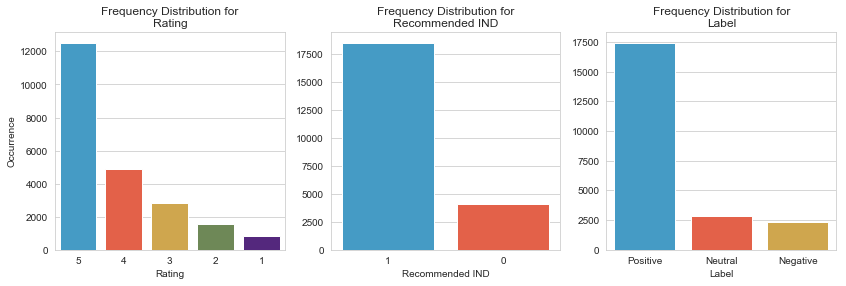

In [101]:
# Distribution of Rating, Recommended IND, and Label:
cat_dtypes = ["Rating", "Recommended IND", "Label"]
increment = 0
f, axes = plt.subplots(1, len(cat_dtypes), figsize=(14, 4), sharex=False)

for i in range(len(cat_dtypes)):
    sns.countplot(x=cat_dtypes[increment],
                  data=df,
                  order=df[cat_dtypes[increment
                                      ]].value_counts().index, ax=axes[i])
    axes[i].set_title(
        "Frequency Distribution for\n{}".format(cat_dtypes[increment]))
    axes[i].set_ylabel("Occurrence")
    axes[i].set_xlabel("{}".format(cat_dtypes[increment]))
    increment += 1
axes[1].set_ylabel("")
axes[2].set_ylabel("")
plt.show()

We have a stark class imbalance of the target variable. As we noted in the EDA, the data is very heavily skewed towards recommendations. For the retailer this isn't a bad problem to have, customers seem to like the products more often than not - and recommend them more often than not. 

For training machine learning models this quite problematic. Predictive models perform better when the data is Guassian - which it is not. This would explain why Gaussian Naive Bayes performed the worst of the bunch.

### Addressing class imbalance

You may recall I did not want to equalize the data based on the target variable earlier on as that would have hindered the previous analyses by artificially reducing the corpus. However, that decision has come back to cause some trouble. 

I could normalize the distribution and rerun everything, or I could either downsample or upsample the data from where I'm at. Rather than downsample the majority class I'm going to upsample the minority class. To do this I'll use the Synthetic Minority Oversampling Technique (SMOTE) from the imbalanced-learn library.

In [102]:
# Import the hopeful solution to our problems
from imblearn.over_sampling import SMOTE
smote = SMOTE()

### Retesting the models with balanced classes

In [103]:
# Setting up new variables for ML
X_sm, y_sm = smote.fit_sample(X_ml, y_ml)

X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(
    X_sm, y_sm, test_size=0.3, random_state=100)

In [104]:
# Defining a new function with revised inputs for the new SMOTE variables


def auto_model_sm(mod, model_name, x_train_sm,
                  y_train_sm, x_test_sm, y_test_sm):
    mod.fit(x_train_sm, y_train_sm)
    print(model_name)
    acc = cross_val_score(mod, X_train_sm, y_train_sm,
                          scoring="accuracy", cv=5)
    predictions = cross_val_predict(mod, X_train_sm, y_train_sm, cv=5)
    print("Accuracy:", round(acc.mean(), 3))
    cm = confusion_matrix(predictions, y_train_sm)
    print("Confusion Matrix:  \n", cm)
    print("                    Classification Report \n",
          classification_report(predictions, y_train_sm))

In [105]:
# 1. Gaussian Naive Bayes
gnb = GaussianNB()
auto_model_sm(gnb, "Gaussian Naive Bayes", X_train_sm,
              y_train_sm, X_test_sm, y_test_sm)

Gaussian Naive Bayes
Accuracy: 0.662
Confusion Matrix:  
 [[8575 4482]
 [3957 7976]]
                    Classification Report 
               precision    recall  f1-score   support

           0       0.68      0.66      0.67     13057
           1       0.64      0.67      0.65     11933

   micro avg       0.66      0.66      0.66     24990
   macro avg       0.66      0.66      0.66     24990
weighted avg       0.66      0.66      0.66     24990



All right! Still not the best, but we at least have comparable f1 scores. This means the model is equally able to identify whether or not the customer Recommended the product.

In [106]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100)
auto_model_sm(rfc, "Random Forest Classifier", X_train_sm,
              y_train_sm, X_test_sm, y_test_sm)

Random Forest Classifier
Accuracy: 0.894
Confusion Matrix:  
 [[10459   560]
 [ 2073 11898]]
                    Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.95      0.89     11019
           1       0.96      0.85      0.90     13971

   micro avg       0.89      0.89      0.89     24990
   macro avg       0.89      0.90      0.89     24990
weighted avg       0.90      0.89      0.90     24990



Now we're cooking with gas! We've got a model with a mean CV of 89% and a pretty decent f1-score for both outcomes.

In [107]:
# Logistic Regression
log = LogisticRegression(solver='lbfgs')
auto_model_sm(log, "Logistic Regression", X_train_sm,
              y_train_sm, X_test_sm, y_test_sm)

Logistic Regression
Accuracy: 0.599
Confusion Matrix:  
 [[7837 5314]
 [4695 7144]]
                    Classification Report 
               precision    recall  f1-score   support

           0       0.63      0.60      0.61     13151
           1       0.57      0.60      0.59     11839

   micro avg       0.60      0.60      0.60     24990
   macro avg       0.60      0.60      0.60     24990
weighted avg       0.60      0.60      0.60     24990



In [108]:
# Linear SVC
svc = LinearSVC()
auto_model_sm(svc, "Linear SVC", X_train_sm, y_train_sm, X_test_sm, y_test_sm)

Linear SVC
Accuracy: 0.6
Confusion Matrix:  
 [[7899 5352]
 [4633 7106]]
                    Classification Report 
               precision    recall  f1-score   support

           0       0.63      0.60      0.61     13251
           1       0.57      0.61      0.59     11739

   micro avg       0.60      0.60      0.60     24990
   macro avg       0.60      0.60      0.60     24990
weighted avg       0.60      0.60      0.60     24990



### Tuning the Best Model: Random Forest

In [110]:
# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [2, 10, 100, 200],
    'min_samples_leaf': [2, 5, 10, 50],
    'min_samples_split': [2, 5, 10, 50],
    'n_estimators': [100, 400, 600, 1000]
}

rfcfit = rfc.fit(X_train_sm, y_train_sm)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfcfit, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_sm, y_train_sm)

# Getting the best hyperparameters
grid_search.best_params_

Fitting 3 folds for each of 512 candidates, totalling 1536 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   52.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 72.1min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 108.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 219.6min
[Parallel(n_jobs=-1)]: Done 1536 out of 1536 | elapsed: 242.8min finished


{'bootstrap': False,
 'max_depth': 200,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [111]:
# Random Forest Classifier
rfc = RandomForestClassifier(bootstrap=False, max_depth=200, 
                             min_samples_leaf=2, min_samples_split=2,
                             n_estimators=1000)
auto_model_sm(rfc, "Random Forest Classifier", X_train_sm,
              y_train_sm, X_test_sm, y_test_sm)

Random Forest Classifier
Accuracy: 0.893
Confusion Matrix:  
 [[10197   331]
 [ 2335 12127]]
                    Classification Report 
               precision    recall  f1-score   support

           0       0.81      0.97      0.88     10528
           1       0.97      0.84      0.90     14462

   micro avg       0.89      0.89      0.89     24990
   macro avg       0.89      0.90      0.89     24990
weighted avg       0.91      0.89      0.89     24990



In [112]:
# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [False],
    'max_depth': [200, 300, 500, 700],
    'min_samples_leaf': [2, 3],
    'min_samples_split': [2, 3],
    'n_estimators': [100, 400, 600, 1000]
}

rfcfit = rfc.fit(X_train_sm, y_train_sm)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfcfit, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_sm, y_train_sm)

# Getting the best hyperparameters
grid_search.best_params_

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 50.8min
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 67.0min finished


{'bootstrap': False,
 'max_depth': 300,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 400}

In [30]:
# Random Forest Classifier
rfc = RandomForestClassifier(bootstrap=False, max_depth=300, 
                             min_samples_leaf=2, min_samples_split=3,
                             n_estimators=400)
auto_model_sm(rfc, "Random Forest Classifier", X_train_sm,
              y_train_sm, X_test_sm, y_test_sm)

NameError: name 'auto_model_sm' is not defined

These hyperparameters strike a solid balance of performance and speed.

In [114]:
# Creating a plot for feature importance
def importance_plotting(data,x,y,palette,title):
    sns.set(style="whitegrid")
    ft = sns.PairGrid(data,y_vars=y,x_vars=x,size=5,aspect=1)
    ft.map(sns.stripplot,orient='h',palette=palette, edgecolor="black",size=15)
    for ax, title in zip(ft.axes.flat, titles):
        
    # Set a different title for each axes
        ax.set(title=title)
        
    # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)

    plt.show()

C:\Users\Zack\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


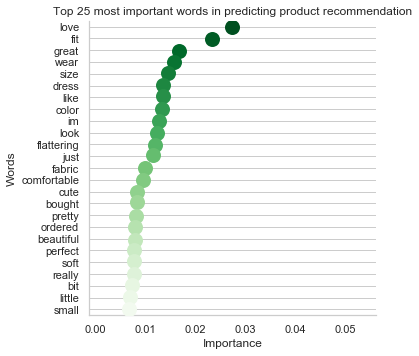

In [117]:
# Compile arrays of columns (words) and feature importances
feat_import = {'Words':ml_model.drop('Recommended IND',axis=1).columns.tolist(),'Importance':rfc.feature_importances_}

# Bung these into a dataframe, rank highest to lowest then slice top 20
Importance = pd.DataFrame(feat_import,index=None).sort_values('Importance',ascending=False).head(25)

# Plot the graph!
titles = ["Top 25 most important words in predicting product recommendation"]
importance_plotting(Importance,'Importance','Words','Greens_r',titles)

We can glean that things such as fit, size, and color are big contributors to whether a reviewer recommends the product. This can be used by the retailer to make data driven choices about what future products to offer.

## Precision-Recall
The precision-recall curve shows the tradeoff between precision and recall for different thresholds. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.

In [29]:
# Getting prediction probabilities
y_scores = rfc.predict_proba(X_train_sm)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_train_sm, y_scores)

# Defining a new function to plot the precision-recall curve
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("Threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

NameError: name 'rfc' is not defined

We can see that a Threshold of 0.7 may be ideal, any higher and recall drops rather sharply.

## AUC-ROC Curve
AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. 

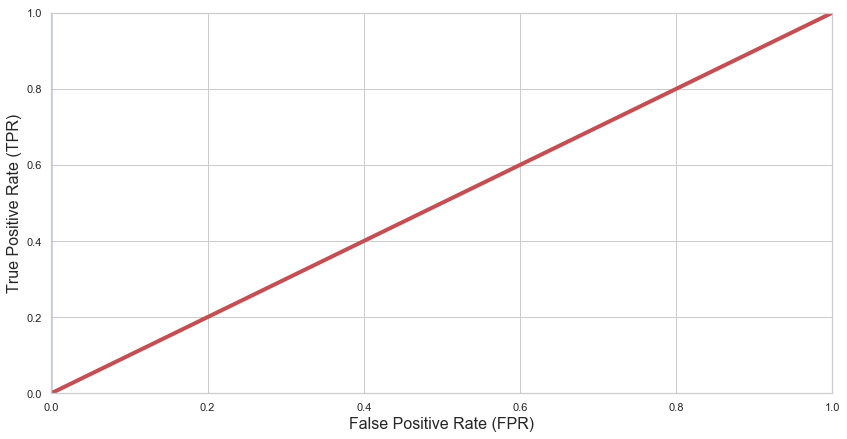

In [119]:
# Compute the true positive and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_sm, y_scores)

# Plotting the true positive and false positive rate
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.tight_layout()
plt.show()

## Revisiting Cluster Analysis

In [223]:
# TSNE
n_sne = 7000


time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_train_sm)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 24990 samples in 2.529s...
[t-SNE] Computed neighbors for 24990 samples in 787.032s...
[t-SNE] Computed conditional probabilities for sample 1000 / 24990
[t-SNE] Computed conditional probabilities for sample 2000 / 24990
[t-SNE] Computed conditional probabilities for sample 3000 / 24990
[t-SNE] Computed conditional probabilities for sample 4000 / 24990
[t-SNE] Computed conditional probabilities for sample 5000 / 24990
[t-SNE] Computed conditional probabilities for sample 6000 / 24990
[t-SNE] Computed conditional probabilities for sample 7000 / 24990
[t-SNE] Computed conditional probabilities for sample 8000 / 24990
[t-SNE] Computed conditional probabilities for sample 9000 / 24990
[t-SNE] Computed conditional probabilities for sample 10000 / 24990
[t-SNE] Computed conditional probabilities for sample 11000 / 24990
[t-SNE] Computed conditional probabilities for sample 12000 / 24990
[t-SNE] Computed conditional probabilities for 

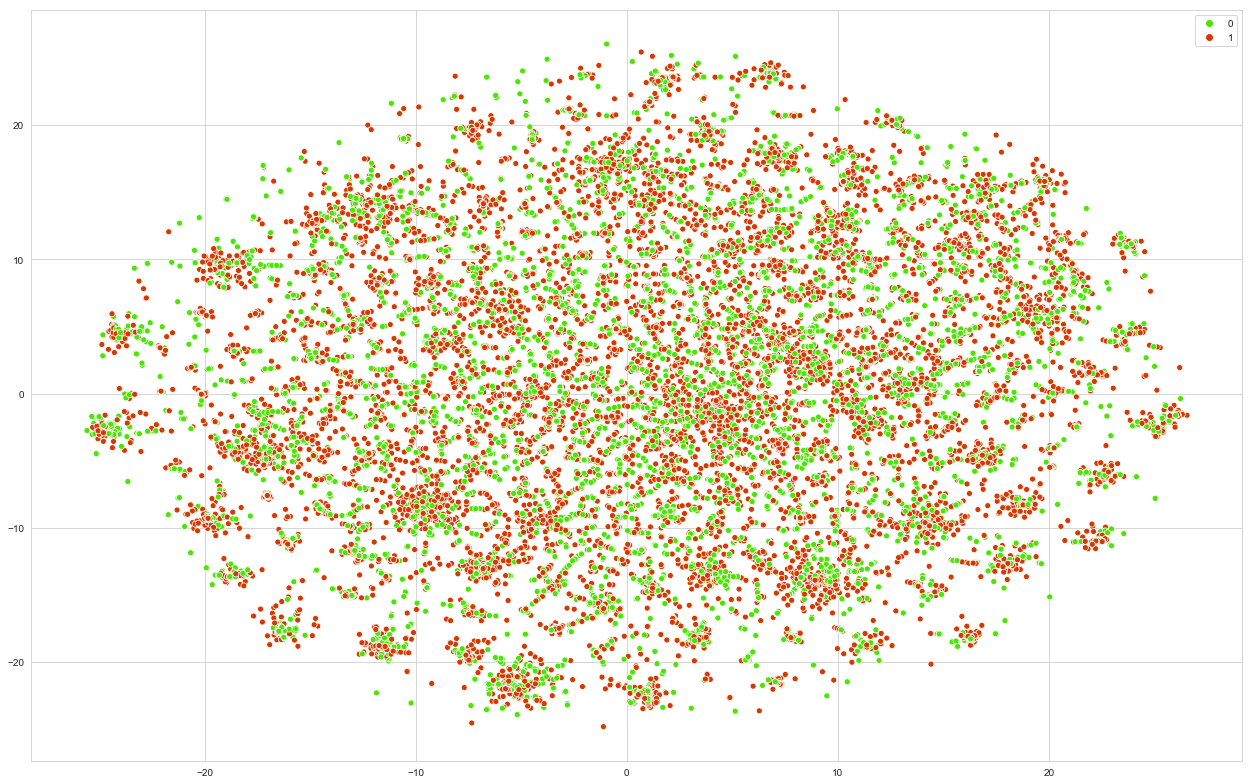

In [224]:
a4_dims = (17.5, 11)
fig, ax = plt.subplots(figsize=a4_dims)
flatui = ["#4ae500", "#d63900"]
order = [0, 1]

sns.scatterplot(tsne_results[:, 0], tsne_results[:, 1],
                hue=y_train_sm, palette=flatui,
                hue_order=order,
                ax=ax)
plt.tight_layout()